In [4]:
import numpy as np
import cv2

from PIL import Image
import os

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
from ultralytics import YOLO

In [7]:
img_sz=1024

def parse_labels(file_path,yolo=False):
    labels = []
    with open(file_path, 'r') as file:
        if(yolo):
            splitted=file_path.split("/")
            imagename=splitted[3][:-4]+".png"
            
            image = Image.open(os.path.join(splitted[0],splitted[1],"images",imagename))
        for line in file:
            parts = line.strip().split()
            x = float(parts[1])
            y = float(parts[2])
            x_width = float(parts[3])
            y_width = float(parts[4])
            if(yolo):
                x,y,x_width,y_width=x*image.width,y*image.height,x_width*image.width,y_width*image.height
                x1,y1,x2,y2=x-x_width,y-y_width,x+x_width,y+y_width
                labels.append((1, x1 ,y1 ,x2, y2))
            else:
                labels.append((1, x,y,x_width,y_width))

        if(len(labels)==0):
            labels.append([])

    return np.array(labels,dtype=np.float32)

def resize_and_pad_image_with_bboxes(image, bboxes, target_height, target_width):
    """
    Resize and pad an image and adjust bounding boxes to the target dimensions.

    Args:
    - image (numpy.ndarray): Input image as a numpy array (H, W, C).
    - bboxes (list of tuples): List of bounding boxes [(xmin, ymin, xmax, ymax), ...].
    - target_height (int): Desired height of the output image.
    - target_width (int): Desired width of the output image.

    Returns:
    - numpy.ndarray: Resized and padded image.
    - list of tuples: Adjusted bounding boxes.
    """
    # Convert numpy array to PIL Image for resizing
    pil_image = Image.fromarray(image)

    # Calculate the aspect ratio of the image and the target dimensions
    original_width, original_height = pil_image.size
    aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height

    # Determine the new size of the image while maintaining the aspect ratio
    if aspect_ratio > target_aspect_ratio:
        # Image is wider than the target aspect ratio
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Image is taller than or equal to the target aspect ratio
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image
    resized_image = pil_image.resize((new_width, new_height))
    
    # Convert back to numpy array
    resized_image_np = np.array(resized_image)

    # Calculate scale factors for bounding boxes
    x_scale = new_width / original_width
    y_scale = new_height / original_height

    # Resize bounding boxes
    resized_bboxes = [(int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale)) for xmin, ymin, xmax, ymax in bboxes]
    # print(resized_bboxes,"res")
    # Calculate padding to achieve the target dimensions
    pad_height = target_height - new_height
    pad_width = target_width - new_width
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    # print(new_height,"nh")
    # print(new_width,"nw")
    # print(pad_height,"h")
    # print(pad_width,"w")
    # print(pad_top,"t")
    # print(pad_left,"l")
    # print()

    # Pad the image
    padded_image = np.pad(resized_image_np,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant',
        constant_values=255)

    # Adjust bounding boxes for padding
    padded_bboxes = [(xmin + pad_left, ymin + pad_top, xmax + pad_left, ymax + pad_top) for xmin, ymin, xmax, ymax in resized_bboxes]
    # print("done")
    return padded_image, padded_bboxes

In [8]:

class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        # self.images=[cv2.imread(dir, cv2.IMREAD_GRAYSCALE) for dir in image_paths]
        self.labels = labels
        self.targets = []
        for i in range(len(image_paths)):
            self.targets.append(resize_and_pad_image_with_bboxes(cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE),
                                                                 labels[i][:,1:],img_sz,img_sz))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image,cord = self.targets[idx]
        # end2 = time.time()
        label = self.labels[idx]
        
        if(len(label)>0 and label[0][0]!=0):
            classOf=label[:,0]
            image = torch.as_tensor(np.expand_dims(image/255,0))
            classOf=torch.as_tensor(classOf,dtype=torch.int64)
            cord=torch.as_tensor(cord,dtype=torch.float32)
        else:
            image = torch.as_tensor(np.expand_dims(image/255,0))
            classOf=torch.as_tensor([0],dtype=torch.int64)
            cord=torch.as_tensor(cord,dtype=torch.float32)

        label={
            "labels": classOf,
            "boxes": cord
        }
        return image, label

def collate_fn(batch):
  return tuple(zip(*batch))

take_directory_vi="prodData/test/images/"
take_directory_vl="prodRcnnLabels/test/labels/"

image_paths_val=[take_directory_vi+dir for dir in os.listdir(take_directory_vi)]
labels_val=[np.array(parse_labels(take_directory_vl+file)) for file in os.listdir(take_directory_vl)]

print(f"v/i {len(image_paths_val)} v/l {len(labels_val)}")


v/i 1499 v/l 1499


In [13]:

classes = ["Background", "cancer"]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = len(classes)  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

Using cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
i=0
for l in labels_val:
    for el in l:
        i+=1

print(i)

1905


In [11]:
dataset_val = MammogramDataset(image_paths_val, labels_val)

data_loader_val = torch.utils.data.DataLoader(
  dataset_val, batch_size=1, shuffle=False,collate_fn=collate_fn)

In [12]:
weights = torch.load("RCNN/output-end_prod1/best_model.pth")
model.load_state_dict(weights['model_state_dict'])

<All keys matched successfully>

In [13]:
def predictRCNN(data_loader):
    outputs=[]
    for i, data in enumerate(data_loader):
        images, labels = data

        images = list(image.to(device).float() for image in images)
        
        with torch.no_grad():
            model.eval()
            outputs.append(model(images)) 
    return outputs

In [14]:
rOutputs=predictRCNN(data_loader_val)

In [21]:
ymodel = YOLO('runs/detect/yolov8n_prod4(0.46)/weights/best.pt')
yOutputs=[]

dir=take_directory_vi
for file in os.listdir(dir):
    image_path = os.path.join(dir,file)

    image = cv2.imread(image_path)

    yOutputs.append(ymodel.predict(image,imgsz=1024)[0].boxes)
# yOutputs


0: 1024x832 (no detections), 76.7ms
Speed: 14.2ms preprocess, 76.7ms inference, 8.4ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 6.5ms
Speed: 6.4ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 6.4ms
Speed: 6.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 6.8ms
Speed: 5.9ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 3.9ms
Speed: 6.9ms preprocess, 3.9ms inference, 5.2ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 7.2ms
Speed: 7.0ms preprocess, 7.2ms inference, 6.8ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 0.4ms
Speed: 6.4ms preprocess, 0.4ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 832)

0: 1024x832 (no detections), 7.3ms
Speed: 6.6ms preprocess, 7.3ms

In [22]:
confScore=0.5

def yoloParser(boxObject):
    logic=boxObject.conf>.55
    cords=np.array(boxObject.xyxy[logic].cpu())
    y,x=cords.shape
    answer=np.zeros((y,x+3))
    answer[:,0:x]=cords
    answer[:,4]=boxObject.conf[logic].cpu()
    answer[:,5]=boxObject.cls[logic].cpu()+1
    answer[:,6]=0
    return answer

def rcnnParser(boxObject):
    logic=boxObject[0]["scores"]>0.6
    cords=np.array(boxObject[0]["boxes"][logic].cpu())
    y,x=cords.shape
    answer=np.zeros((y,x+3))
    answer[:,0:x]=cords
    answer[:,4]=boxObject[0]["scores"][logic].cpu()
    answer[:,5]=boxObject[0]["labels"][logic].cpu()
    answer[:,6]=1
    return answer

def undo_resize_and_pad_image_with_bboxes(padded_bboxes, origShape ):
    """
    Undo the resizing and padding of bounding boxes to their original dimensions.

    Args:
    - padded_bboxes (list of tuples): List of padded bounding boxes [(xmin, ymin, xmax, ymax), ...].
    - original_height (int): Original height of the image before resizing.
    - original_width (int): Original width of the image before resizing.
    - target_height (int): Height of the resized and padded image.
    - target_width (int): Width of the resized and padded image.

    Returns:
    - list of tuples: Bounding boxes adjusted to the original dimensions.
    """
    padded_bboxes=tuple(padded_bboxes)
    target_height,target_width = origShape
    original_height=original_width= img_sz
    # Calculate the aspect ratio of the original and target dimensions
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height

    # Determine the new size of the image while maintaining the aspect ratio
    if original_aspect_ratio < target_aspect_ratio:
        # Image was wider than the target aspect ratio
        new_width = target_width
        new_height = int(target_width / original_aspect_ratio)
    else:
        # Image was taller than or equal to the target aspect ratio
        new_height = target_height
        new_width = int(target_height * original_aspect_ratio)

    # Calculate padding added to achieve the target dimensions
    
    # Calculate scale factors for bounding boxes
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    pad_height =np.ceil((new_height - target_height) / y_scale)
    pad_width = np.ceil((new_width-target_width) / x_scale)
    pad_top = pad_height // 2 
    pad_left = pad_width // 2 
    # print(new_height,"nh")
    # print(new_width,"nw")
    # print(pad_height,"h")
    # print(pad_width,"w")
    # print(pad_top,"t")
    # print(pad_left,"l")
    # print(x_scale,"xs")
    # print(y_scale,"ys")
    def non_negative(x):
        return max(x, 0)
    # Remove padding from bounding boxes
    unpadded_bboxes = [np.asarray((xmin - pad_left, ymin - pad_top, xmax - pad_left, ymax - pad_top)) for xmin, ymin, xmax, ymax in padded_bboxes]
    # print(unpadded_bboxes)
    # # Undo the resizing of bounding boxes
    original_bboxes = [np.asarray((non_negative(np.ceil(xmin * x_scale)), non_negative(np.ceil(ymin * y_scale)), non_negative(np.ceil(xmax * x_scale)), non_negative(np.ceil(ymax * y_scale)))) for xmin, ymin, xmax, ymax in unpadded_bboxes]
    return np.array(original_bboxes,dtype=np.float32)


In [23]:
def iou(bb1, bb2):

    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def non_max_suppression(detections, iou_threshold=0.2):
    if len(detections) == 0:
        return []

    # Sort detections by confidence score
    npArrayVer=np.array(detections)
    # if npArrayVer[:,6].mean()==1:
    #     npArrayVer[:,4]-=0.35
    #     detections=npArrayVer[npArrayVer[:,4]>0.6]
    detections = sorted(detections, key=lambda x: x[4], reverse=True)
    selected_detections = []

    while len(detections) > 0:
        # Select the detection with the highest score
        best_detection = detections.pop(0)
        selected_detections.append(best_detection)

        # Suppress detections with high overlap
        detections = [d for d in detections if iou(best_detection, d) < iou_threshold]

    return selected_detections

In [26]:
predictions=[]
for c in range(len(image_paths_val)):
    yoloVal=yoloParser(yOutputs[c])
    rcnnVal=rcnnParser(rOutputs[c])
    if(len(rcnnVal)!=0):
        rcnnVal[:,:4]=undo_resize_and_pad_image_with_bboxes(rcnnVal[:,:4], yOutputs[c].orig_shape)
    combined=np.vstack((yoloVal,rcnnVal))
    sup=non_max_suppression(combined)
    # sup=yoloVal
    # if(len(sup)==0):
    #     predictions.append([-1])
    # else:
    #     predictions.append(sup)
    predictions.append(yoloVal)

In [33]:
np.array(predictions[902])[np.array(predictions[902])[:,4]-0.3>0.6]

array([], shape=(0, 7), dtype=float64)

In [17]:
len(predictions)

1499

In [18]:
i=0
for c in range(len(image_paths_val)):
    yoloVal=yoloParser(yOutputs[c])
    for l in yoloVal:
        i+=1
print(i)

214


In [19]:
i=0
for c in range(len(image_paths_val)):
    rcnnVal=rcnnParser(rOutputs[c])
    for l in rcnnVal:
        i+=1
print(i)

1289


In [20]:
i=0
for c in labels_val:
    i+=c[:,0].mean()==0
print(i)

763


In [ ]:
i=0
for c in predictions:
    i+=len(c)>0
print(i)

648


In [140]:
predictions

[[-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],

In [20]:
from torchvision.ops import box_iou

val_loss_list = []
TP, FP, FN = 0, 0, 0
background=0
iou_threshold=0.5
for i, data in enumerate(labels_val):
    labels = data
    outputs=torch.Tensor(np.array(predictions[i])).to(device)
    if(len(data[0])==0):
        if(len(outputs)!=0):
            FN+=1
        continue
    targets = [{
        "labels": torch.tensor(np.array(float(label[0]))),
        "boxes": torch.tensor([label[1:]])
    } for label in labels]
        

    # Calculate TP, FP, FN for F1 score
    for target,output in zip(targets, outputs):
        true_boxes = target["boxes"]
        # print(target)
        # print(output)
        # print(i)

        pred_boxes=np.array(predictions[i])
        if len(pred_boxes) == 0 and target["labels"].item()==0:
            background+=1
            continue
        elif len(pred_boxes) == 0:
            FN += len(true_boxes)
            continue
        
        pred_boxes = torch.tensor(pred_boxes[:,:4])
        # pred_scores = output["scores"]
        #TODO do it later
        # pred_labels = output["labels"]
        ious = box_iou(pred_boxes, true_boxes)
        iou_max, iou_idx = ious.max(dim=1)
        # print(iou_max)
        # Calculate TP, FP, FN
        for iou, idx in zip(iou_max, iou_idx):
            if iou >= iou_threshold:
                TP += 1
            else:
                FP += 1

        FN += len(true_boxes) - ious.max(dim=0)[0].ge(iou_threshold).sum().item()
        
    # Calculate precision, recall, and F1 score
print(TP,FP,FN)
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
print(background)

[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0


none Precision: 0.3710, Recall: 0.5764, F1 Score: 0.4514
-0.34 Precision: 0.3959, Recall: 0.3870, F1 Score: 0.3914  755
-0.2 Precision: 0.4103, Recall: 0.5197, F1 Score: 0.4586   739
-0.15 Precision: 0.4047, Recall: 0.5401, F1 Score: 0.4627   733
-0.1 Precision: 0.3993, Recall: 0.5555, F1 Score: 0.4646    724
-0.07 Precision: 0.3977, Recall: 0.5626, F1 Score: 0.4660  723

-0.05 Precision: 0.3956, Recall: 0.5684, F1 Score: 0.4666  721

-0.03 Precision: 0.3930, Recall: 0.5713, F1 Score: 0.4656  713

-0.35 Precision: 0.4833, Recall: 0.8535, F1 Score: 0.6171
-0.30 Precision: 0.4981, Recall: 0.7907, F1 Score: 0.6112

In [176]:
import pickle

# Assuming your array is called 'big_array'
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [1]:
import pickle
# Load the array
with open('predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

In [27]:
#############################################################################################################################
#RESİMLERİ KIRPMA
#############################################################################################################################
import os
import cv2

# Klasör yolları
output_folder = "predictions4"
# Klasör yoksa oluştur
os.makedirs(output_folder, exist_ok=True)
croppedImagePaths=[]

# Her bir label dosyasını oku
i=0
for label_file in predictions:
    # İlgili resim dosyasını oku
    image_path=image_paths_val[i]
    labels = label_file

    if not os.path.exists(image_path):
        print(f"Resim bulunamadı: {image_path}")
        continue

    # Resmi yükle
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Eğer label dosyası boşsa atla
    if len(labels)<=0:
        print(i)
        i+=1
        continue

    # Her bir satır için kırpma işlemini gerçekleştir
    currentTotalImages=[]
    for idx, label in enumerate(labels):
        if len(label) != 7:
            print(f"Label formatı yanlış: {label}")
            continue
        x1, y1, x2, y2 = map(float, label[:4])

        # Koordinatları ve boyutları hesapla

        x1 = int(x1  - 50)
        y1 = int(y1  - 50)
        x2 = int(x2 + 50)
        y2 = int(y2  + 50)

        # Koordinatları sınırla
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Resmi kırp
        # cropped_image = image[y1:y2, x1:x2]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 7)
        # cv2.putText(image, "cancer", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cropped_image = image

        # Yeni dosya ismini oluştur
        #can create dependencies
        image_file=image_path.split("/")[-1]
        output_image_file = f"{os.path.splitext(image_file)[0]}_{idx}.png"
        output_image_path = os.path.join(output_folder, output_image_file)
        currentTotalImages.append(output_image_path)
        # Kırpılan resmi kaydet
    cv2.imwrite(output_image_path, cropped_image)

    croppedImagePaths.append((currentTotalImages,i))

    print(i)
    i+=1

print("Kırpma işlemi tamamlandı.")
print(len(croppedImagePaths))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

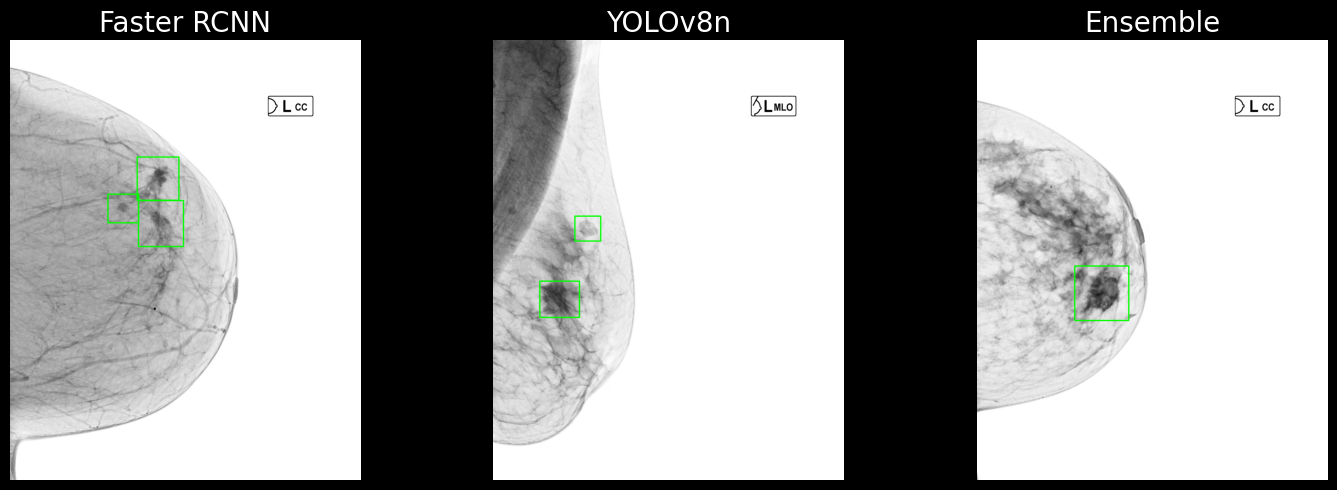

In [31]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
image1 = Image.open('predictions3/Kategori4Sol_12147_LCC_2.png')
image2 = Image.open('predictions4/Kategori5Sol_12589_LMLO_1.png')
image3 = Image.open('predictions2/Kategori5Sol_12526_LCC_0.png')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='black')

# Display images in the subplots
axs[0].imshow(image1)
axs[0].axis('off')  # Hide axes
axs[0].set_title('Faster RCNN',fontsize=20, color='white')
axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('YOLOv8n',fontsize=20, color='white')
axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Ensemble',fontsize=20, color='white')

# Adjust layout
plt.tight_layout()

# Save the figure
output_path = 'combined_image.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [33]:
import pickle

# Assuming your array is called 'big_array'
with open('croppedImagePaths.pkl', 'wb') as f:
    pickle.dump(croppedImagePaths, f)


In [ ]:
import pickle
# Load the array
with open('croppedImagePaths.pkl', 'rb') as f:
    croppedImagePaths = pickle.load(f)

In [61]:
answers=labels_val

In [4]:
def massParse(file_path):
    calcMassDic={
    "0":1,"1":-1
    }
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip()
            labels.append(int(calcMassDic[parts]))

    return np.array(labels,dtype=np.int32)
take_directory_mass="massCalcLabels/test/labels/"

labels_mass=[massParse(take_directory_mass+file) for file in os.listdir(take_directory_mass)]
labels_mass_temp=[]
for f in labels_mass:
    for value in f:
        labels_mass_temp.append(int(value))

labels_mass=labels_mass_temp

In [11]:
inkkk=0
for id,label in enumerate(answers):
    biradsClass=int(image_paths_val[id].split("/")[-1][8])
    # print(image_paths_val[id])
    for id2,cor in enumerate(label):
        if(cor[0]!=0):
            # print(biradsClass,float(labels_mass[inkkk]))
            # print(biradsClass*labels_mass[inkkk])
            # print(type(float(biradsClass*labels_mass[inkkk])))
            answers[id][id2,0]=biradsClass*int(labels_mass[inkkk])
            inkkk+=1

In [34]:
import pickle

# Assuming your array is called 'big_array'
with open('answers.pkl', 'wb') as f:
    pickle.dump(answers, f)


In [68]:
import pickle
# Load the array
with open('answers.pkl', 'rb') as f:
    answers = pickle.load(f)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

img_height, img_width = 512, 512

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the top layers of the model
for layer in base_model.layers[-2:]:  # Unfreeze the top 2 layers
    layer.trainable = True

efficient_net = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
efficient_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

efficient_net.build((None, img_height, img_width, 3))  # Explicitly build the model with the input shape

# efficient_net.summary()
# Load weights
efficient_net.load_weights("extraModels/model_weights_best_f1.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
# Tahmin fonksiyonu
def predict_single_image(model, img_path, img_height, img_width, class_names):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    
    return predicted_class_name, predictions

# Test etmek istediğiniz resmin yolu
output_folder_for_pred=output_folder

# Sınıf isimlerini alın
class_names = ['birads2', 'birads4', 'birads5']
classDic={
    'birads2':2, 'birads4':4, 'birads5':5
}
#TODO fit this
calcMassDic={
    "mass":1,"calcification":-1
}
for path in croppedImagePaths:
    # i=0
    # print(path)
    for label in path[0]:
        predicted_class_name, predictionsImage = predict_single_image(efficient_net, label, img_height, img_width, class_names)
        #TODO load the second model and get predictions
        class_code=classDic[predicted_class_name]
        #TODO add mass calc
        predictions[path[1]][i][-2]=class_code
        # i+=1


# predicted_class_name, predictionsImage = predict_single_image(efficient_net, img_path, img_height, img_width, class_names)

# predictions_percent = np.round(predictionsImage * 100, 2)

# print(f'Tahmin edilen sınıf: {predicted_class_name}')
# for i, class_name in enumerate(class_names):
#     print(f'{class_name}: {predictions_percent[0][i]}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Tahmin edilen sınıf: birads2
birads2: 77.94000244140625%
birads4: 18.780000686645508%
birads5: 3.2799999713897705%


In [69]:
answers

[array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtype=float32),
 array([[          0,           0,           0,        1024,        1024]], dtyp

In [64]:
import pickle
# Load the array
with open('predictions3.pkl', 'rb') as f:
    predictions = pickle.load(f)

In [72]:
from torchvision.ops import box_iou

val_loss_list = []
TP, FP, FN = 0, 0, 0
background=0
iou_threshold=0.5

# Initialize data structures for mAP calculation
all_true_boxes = []
all_pred_boxes = []
all_true_labels = []
all_pred_labels = []
all_pred_scores = []

for i, data in enumerate(answers):
    labels = data
    targets = [{
        "labels": torch.tensor(np.array(float(label[0]))),
        "boxes": torch.tensor(np.array([label[1:]]))
    } for label in labels]
        
    outputs=torch.Tensor(np.array(predictions[i])).to(device)

    # Calculate TP, FP, FN for F1 score
    for target,output in zip(targets, outputs):
        true_boxes = target["boxes"]
        true_labels = target["labels"]
        # print(target["labels"])

        pred_boxes=np.array(predictions[i])
        if len(pred_boxes) == 0 and target["labels"].item()==0:
            background+=1
            continue
        elif len(pred_boxes) == 0:
            FN += len(true_boxes)
            continue
        
        all_true_boxes.append(torch.tensor(np.array(true_boxes)))
        all_pred_boxes.append(torch.tensor(pred_boxes[:,:4]))
        all_true_labels.append(torch.tensor(np.array(true_labels)))
        all_pred_labels.append(torch.tensor(pred_boxes[:,5]))
        all_pred_scores.append(torch.tensor(pred_boxes[:,4]))

        pred_boxes = torch.tensor(pred_boxes[:,:4])

        ious = box_iou(pred_boxes, true_boxes)
        iou_max, iou_idx = ious.max(dim=1)

        # Store true and predicted boxes and labels for mAP calculation

        # Calculate TP, FP, FN
        for iou, idx in zip(iou_max, iou_idx):
            if iou >= iou_threshold:
                TP += 1
            else:
                FP += 1

        FN += len(true_boxes) - ious.max(dim=0)[0].ge(iou_threshold).sum().item()
        
    # Calculate precision, recall, and F1 score
print(TP,FP,FN)
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
print(background)

def calculate_ap(true_boxes, pred_boxes, scores, labels, iou_thresholds):
    ap_list = []
    for iou_threshold in iou_thresholds:
        sorted_indices = np.argsort(-scores)
        pred_boxes_sorted = pred_boxes[sorted_indices]
        pred_labels_sorted = labels[sorted_indices]

        true_positives = np.zeros(len(pred_boxes_sorted))
        false_positives = np.zeros(len(pred_boxes_sorted))
        detected = []

        for i, pred_box in enumerate(pred_boxes_sorted):
            best_iou = 0
            best_gt_idx = -1

            for j, true_box in enumerate(true_boxes):
                if j in detected:
                    continue
                iou = box_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0)).item()
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
            if best_iou > iou_threshold and pred_labels_sorted[i].item() == true_labels.item():
                true_positives[i] = 1
                detected.append(best_gt_idx)
            else:
                false_positives[i] = 1

        cumulative_tp = np.cumsum(true_positives)
        cumulative_fp = np.cumsum(false_positives)

        precision = cumulative_tp / (cumulative_tp + cumulative_fp)
        recall = cumulative_tp / len(true_boxes)

        ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])
        ap_list.append(ap)
    return np.mean(ap_list)

def calculate_ar(true_boxes, pred_boxes, scores, labels, max_detections, iou_threshold):
    ar_list = []
    for max_det in max_detections:
        if max_det > len(pred_boxes):
            continue  # Skip if max_det is larger than available predictions

        sorted_indices = np.argsort(-scores)
        pred_boxes_sorted = pred_boxes[sorted_indices][:max_det]
        pred_labels_sorted = labels[sorted_indices][:max_det]

        true_positives = np.zeros(len(pred_boxes_sorted))
        detected = []

        for i, pred_box in enumerate(pred_boxes_sorted):
            best_iou = 0
            best_gt_idx = -1

            for j, true_box in enumerate(true_boxes):
                if j in detected:
                    continue
                iou = box_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0)).item()
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
            if best_iou > iou_threshold and pred_labels_sorted[i].item() == true_labels.item():
                true_positives[i] = 1
                detected.append(best_gt_idx)

        cumulative_tp = np.cumsum(true_positives)
        recall = cumulative_tp / len(true_boxes)
        ar_list.append(recall[-1] if len(recall) > 0 else 0)  # Append recall or 0 if empty
    return np.mean(ar_list)

aps = []
ars = []
iou_thresholds = np.arange(0.5, 1.0, 0.05)  # IOU thresholds from 0.5 to 0.95
max_detections = [1, 10, 100]
for true_boxes, pred_boxes, scores, labels in zip(all_true_boxes, all_pred_boxes, all_pred_scores, all_pred_labels):
    aps.append(calculate_ap(true_boxes, pred_boxes, scores, labels, iou_thresholds))
    ars.append(calculate_ar(true_boxes, pred_boxes, scores, labels, max_detections, iou_thresholds[0]))
print(ars)
mAP = np.mean(aps)
mAR = np.mean(ars)

print(f"mAP: {mAP:.4f}")
print(f"mAR: {mAR:.4f}")

303 324 52
Precision: 0.4833, Recall: 0.8535, F1 Score: 0.6171
0
[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0,